# Preparing

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from joblib import Parallel, delayed
from utils import *
import pdb
import portion as P
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
# matplotlib.rcdefaults()

figures saved to /tmp/figures


In [27]:
DATA_DIR = '../trace-data/'
df = pd.read_csv(DATA_DIR + 'preprocessed.csv') # dataframe of tasks

In [28]:
df

,Unnamed: 0,vc,jobid,num_attemps,user,status,num_gpus,runtime,queue_time,gpu_util_mean,gpu_util_min,gpu_util_max,cpu_util,mem_util,machine_gpu_mem,machine_gpu_num
0,0,11cb48,application_1506638472019_17235,1,066e99,Pass,1,1.100000,0.166667,25.591667,0.0,51.183333,2.108333,95.686876,24GB,8
1,1,6214e9,application_1506638472019_17145,1,2c46d5,Pass,1,49.183333,0.833333,0.000000,0.0,0.000000,48.659673,99.553043,12GB,2
2,2,6c71a0,application_1506638472019_0262,1,a04bf9,Pass,1,14344.366667,0.133333,90.033048,0.0,96.000000,6.554313,98.141959,24GB,8
3,3,6214e9,application_1506638472019_17148,1,2c46d5,Pass,1,45.983333,3.250000,0.000000,0.0,0.000000,18.046454,79.824283,12GB,2
4,4,6214e9,application_1506638472019_17159,1,2c46d5,Pass,1,46.100000,0.550000,0.000000,0.0,0.000000,21.289007,85.083449,12GB,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111606,111606,11cb48,application_1508364558011_30316,1,066e99,Pass,1,0.950000,2.333333,0.000000,0.0,0.000000,0.562500,23.500736,24GB,8
111607,111607,ee9e8c,application_1508364558011_30284,5,686d6e,Failed,8,67.616667,0.266667,0.000000,0.0,0.000000,0.694722,61.297971,12GB,2
111608,111608,6c71a0,application_1508364558011_30313,1,450add,Killed,1,2.750000,1.133333,0.000000,0.0,0.000000,0.572500,22.961763,24GB,8
111609,111609,6c71a0,application_1508364558011_30301,1,450add,Pass,1,31.600000,2.250000,46.726768,0.0,99.316667,7.037121,92.978473,24GB,8


In [29]:
df['machine_gpu_mem'].value_counts()

 12GB    73455
 24GB    38156
Name: machine_gpu_mem, dtype: int64

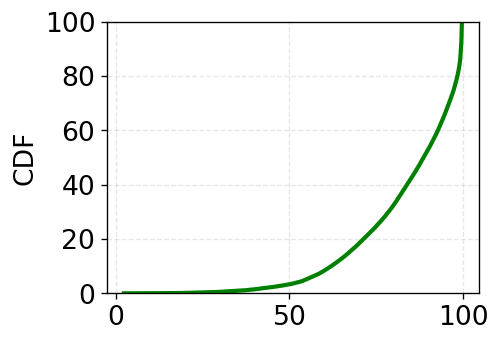

In [4]:
plot_data_cdf(df['mem_util'][~np.isnan(df['mem_util'])], xlog=False)

In [5]:
mean_util = df['gpu_util_mean'][~np.isnan(df['gpu_util_mean'])]
np.percentile(mean_util, 40)

5.370208333333937

In [6]:
top_vc = '6214e9'
multi_attempt = 2

bot_user_thr = get_usr_thr(df['user'], mode='bot')
top_user_thr = get_usr_thr(df['user'], mode='top')
user_counts = df['user'].value_counts()
# top_user = user_counts.index[0]
freq_user = user_counts[user_counts >= top_user_thr].index.to_list() 
new_user = user_counts[user_counts <= bot_user_thr].index.to_list()
# new_user = user_counts[user_counts <= new_usr_thr].index.to_list()
non_pass = ['Failed', 'Killed']
multigpu = 2

runtime_1st = P.closedopen(0, np.percentile(df['runtime'], 25))
runtime_2nd = P.closedopen(np.percentile(df['runtime'], 25), np.percentile(df['runtime'], 50))
runtime_3rd = P.closedopen(np.percentile(df['runtime'], 50), np.percentile(df['runtime'], 75))
runtime_4th = P.closed(np.percentile(df['runtime'], 75), df['runtime'].max())

queue_1st = P.closedopen(0, np.percentile(df['queue_time'], 25))
queue_2nd = P.closedopen(np.percentile(df['queue_time'], 25), np.percentile(df['queue_time'], 50))
queue_3rd = P.closedopen(np.percentile(df['queue_time'], 50), np.percentile(df['queue_time'], 75))
queue_4th = P.closed(np.percentile(df['queue_time'], 75), df['queue_time'].max())

wait_gt_run = 'wait >= run'

In [7]:
mean_util = df['gpu_util_mean'][~np.isnan(df['gpu_util_mean'])]
mean_util_low = P.closedopen(0, np.percentile(mean_util, 36))
mean_util_2nd = P.closedopen(np.percentile(mean_util, 36), np.percentile(mean_util, 50))
mean_util_3rd = P.closedopen(np.percentile(mean_util, 50), np.percentile(mean_util, 75))
mean_util_4th = P.closed(np.percentile(mean_util, 75), mean_util.max())

low_min = 0
high_max = np.percentile(df['gpu_util_max'][~np.isnan(df['gpu_util_max'])], 75)

cpu_util = df['cpu_util'][~np.isnan(df['cpu_util'])]
cpu_util_1st = P.closedopen(0, np.percentile(cpu_util, 25))
cpu_util_2nd = P.closedopen(np.percentile(cpu_util, 25), np.percentile(cpu_util, 50))
cpu_util_3rd = P.closedopen(np.percentile(cpu_util, 50), np.percentile(cpu_util, 75))
cpu_util_4th = P.closed(np.percentile(cpu_util, 75), cpu_util.max())

mem_util = df['mem_util'][~np.isnan(df['mem_util'])]
mem_util_1st = P.closedopen(0, np.percentile(mem_util, 25))
mem_util_2nd = P.closedopen(np.percentile(mem_util, 25), np.percentile(mem_util, 50))
mem_util_3rd = P.closedopen(np.percentile(mem_util, 50), np.percentile(mem_util, 75))
mem_util_4th = P.closed(np.percentile(mem_util, 75), mem_util.max())

gpu_24gb = df['machine_gpu_mem'].value_counts().index[1]

In [8]:
def inner_loop(df):
    results = []
    for df_iter in df.iterrows():
        trans = [] # transaction list
        df_row = df_iter[1]
        if df_row['vc'] == top_vc:
            trans.append('top_vc')
        if df_row['num_attemps'] >= multi_attempt:
            trans.append('multi-attempts')
        if df_row['user'] in new_user:
            trans.append('new_user')
        elif df_row['user'] in freq_user:
            trans.append('freq_user')
        if df_row['status'] in non_pass:            
            trans.append(df_row['status'])
#             trans.append('Unsuccessful')
        if df_row['num_gpus'] >= multigpu:
            trans.append('multigpu')
        if df_row['runtime'] in runtime_1st:
            trans.append('runtime_1st')
        elif df_row['runtime'] in runtime_2nd:
            trans.append('runtime_2nd')
        elif df_row['runtime'] in runtime_3rd:
            trans.append('runtime_3rd')
        elif df_row['runtime'] in runtime_4th:
            trans.append('runtime_4th')
            
        if df_row['queue_time'] in queue_1st:
            trans.append('queue_1st')
        elif df_row['queue_time'] in queue_2nd:
            trans.append('queue_2nd')
        elif df_row['queue_time'] in queue_3rd:
            trans.append('queue_3rd')
        elif df_row['queue_time'] in queue_4th:
            trans.append('queue_4th')

        if df_row['queue_time'] >= df_row['runtime']:
            trans.append(wait_gt_run)
            
        mean_gpu_util = df_row['gpu_util_mean']
        if not np.isnan(mean_gpu_util):
            if mean_gpu_util in mean_util_low:
                trans.append('mean_util_low')
            elif mean_gpu_util in mean_util_2nd:
                trans.append('mean_util_2nd')
            elif mean_gpu_util in mean_util_3rd:
                trans.append('mean_util_3rd')
            elif mean_gpu_util in mean_util_4th:
                trans.append('mean_util_4th')
                
        min_gpu_util = df_row['gpu_util_min']
        if not np.isnan(min_gpu_util):
            if min_gpu_util <= low_min:
                trans.append('low_min_gpu_util')
        max_gpu_util = df_row['gpu_util_max']
        if not np.isnan(max_gpu_util):
            if max_gpu_util >= high_max:
                trans.append('high_max_gpu_util')
                
        cpu_util = df_row['cpu_util']
        if not np.isnan(cpu_util):
            if cpu_util in cpu_util_1st:
                trans.append('cpu_util_1st')
            elif cpu_util in cpu_util_2nd:
                trans.append('cpu_util_2nd')
            elif cpu_util in cpu_util_3rd:
                trans.append('cpu_util_3rd')
            elif cpu_util in cpu_util_4th:
                trans.append('cpu_util_4th')
            
        mem_util = df_row['mem_util']
        if not np.isnan(mem_util):
            if mem_util in mem_util_1st:
                trans.append('mem_util_1st')
            elif mem_util in mem_util_2nd:
                trans.append('mem_util_2nd')
            elif mem_util in mem_util_3rd:
                trans.append('mem_util_3rd')
            elif mem_util in mem_util_4th:
                trans.append('mem_util_4th')
                
        if df_row['machine_gpu_mem'] == gpu_24gb:
            trans.append('24GB_GPU')
        results.append(trans)
    return results

In [9]:
df_chunk = pd.read_csv(DATA_DIR + 'preprocessed.csv', chunksize=5000) # tasks with sensor data but sum

In [10]:
usable_cores = os.sched_getaffinity(0)
dataset = Parallel(n_jobs=len(usable_cores))(delayed(inner_loop)(df) for df in df_chunk)

In [11]:
transactions = []
for data in dataset:
    transactions += data

In [18]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)


In [21]:
df.to_csv('transaction.csv')

In [20]:
frequent_itemsets = fpgrowth(df, min_support=0.05, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.635260,(low_min_gpu_util)
1,0.341866,(24GB_GPU)
2,0.249554,(runtime_1st)
3,0.242664,(queue_1st)
4,0.238507,(freq_user)
...,...,...
393,0.091882,"(24GB_GPU, wait >= run)"
394,0.083271,"(low_min_gpu_util, top_vc, wait >= run)"
395,0.095080,"(low_min_gpu_util, mean_util_low, wait >= run)"
396,0.052101,"(low_min_gpu_util, 24GB_GPU, wait >= run)"


In [15]:
from mlxtend.frequent_patterns import association_rules

res = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.7)

In [16]:
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(low_min_gpu_util, runtime_1st)",(mean_util_low),0.103950,0.318902,0.090717,0.872694,2.736557,0.057567,5.350099
1,"(runtime_1st, mean_util_low)",(low_min_gpu_util),0.090771,0.635260,0.090717,0.999408,1.573226,0.033054,615.863548
2,"(runtime_1st, queue_3rd)",(wait >= run),0.063981,0.280411,0.063936,0.999300,3.563691,0.045995,1027.716397
3,"(queue_3rd, wait >= run)",(runtime_1st),0.083961,0.249554,0.063936,0.761498,3.051434,0.042983,3.146500
4,"(mean_util_low, queue_1st)",(low_min_gpu_util),0.076480,0.635260,0.076480,1.000000,1.574159,0.027895,inf
...,...,...,...,...,...,...,...,...,...
99,"(queue_4th, mean_util_low)",(low_min_gpu_util),0.074491,0.635260,0.074455,0.999519,1.573401,0.027134,758.112162
100,"(queue_4th, mean_util_low, wait >= run)",(low_min_gpu_util),0.050362,0.635260,0.050327,0.999288,1.573038,0.018333,512.550934
101,"(runtime_2nd, queue_4th)",(wait >= run),0.063417,0.280411,0.062350,0.983187,3.506231,0.044568,42.800403
102,"(runtime_2nd, wait >= run)",(queue_4th),0.082375,0.250056,0.062350,0.756907,3.026949,0.041752,3.085005


In [17]:
new_df = filter_df(res, 'mean_util_low')
new_df.to_csv('philly_low_util.csv')

# res.to_csv('mined_rules_philly.csv')